In [37]:
import os
import numpy as np
import sys
print(sys.executable)
import sys
sys.path.insert(1, '../src/')
from CNN_classifier_model import CNNClassifier, train_model
from config import raw_data_path, univariate_data_path, processed_data_path
from preprocessing_modules import create_time_windows_with_labels
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import wandb
from sklearn.metrics import accuracy_score, f1_score

wandb.login(key="5f15eb7efc1e0e939ccc83345338a0b8c24e2fbc")


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


/home/nwertheim/miniconda3/bin/python


True

In [38]:
import wandb

wandb.init(project="tcn-time-series-classification", config={
    "model": "TCN",
    "input_length": 12000,
    "batch_size": batch_size,
    "lr": 1e-3,
    "epochs": 10,
    "dropout": 0.2,
    "kernel_size": 7,
    "channels": [32, 64],
})


test_acc,▁███████
test_f1,▁███████
train_loss,█▆▄▂▂▁▁▁
test_acc,0.65962
test_f1,0.79491
train_loss,0.5736


In [39]:
train_dir = os.path.join(univariate_data_path, "target_univariate_train.npy")
train_data = np.load(train_dir, allow_pickle=True)
# train_data = pd.DataFrame(train_data)
test_dir = os.path.join(univariate_data_path, "target_univariate_test.npy")
test_data = np.load(test_dir, allow_pickle=True)
# test_data = pd.DataFrame(test_data)
print(len(train_data))
print(len(test_data))
print(train_data[0])

train_windows = create_time_windows_with_labels(train_data)
test_windows = create_time_windows_with_labels(test_data)

124
32
{'record_name': np.str_('Hopper-2022_08_24_06_55_46-0000010181-0001'), 'signal': array([[ -8.77326634],
       [-16.30170858],
       [-12.15312614],
       ...,
       [  1.94513686],
       [  0.52803341],
       [  2.90890496]]), 'fs': 20, 'preterm': 1}


In [40]:
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.utils.class_weight import compute_class_weight

from collections import Counter

# Example dataset with windows and labels
train_windows, train_labels = create_time_windows_with_labels(train_data)
test_windows, test_labels = create_time_windows_with_labels(test_data)
print(train_windows.shape, train_labels.shape)
# Count label distribution
train_label_counts = Counter(train_labels)
test_label_counts = Counter(test_labels)

# Print the counts
print("Train label distribution:")
print(f"  Term (0): {train_label_counts[0]}")
print(f"  Preterm (1): {train_label_counts[1]}")

print("\nTest label distribution:")
print(f"  Term (0): {test_label_counts[0]}")
print(f"  Preterm (1): {test_label_counts[1]}")

# Convert to tensors
train_windows_tensor = torch.tensor(train_windows, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
test_windows_tensor = torch.tensor(test_windows, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)

train_dataset = TensorDataset(train_windows_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_windows_tensor, test_labels_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

(1071, 12000) (1071,)
Train label distribution:
  Term (0): 319
  Preterm (1): 752

Test label distribution:
  Term (0): 306
  Preterm (1): 593


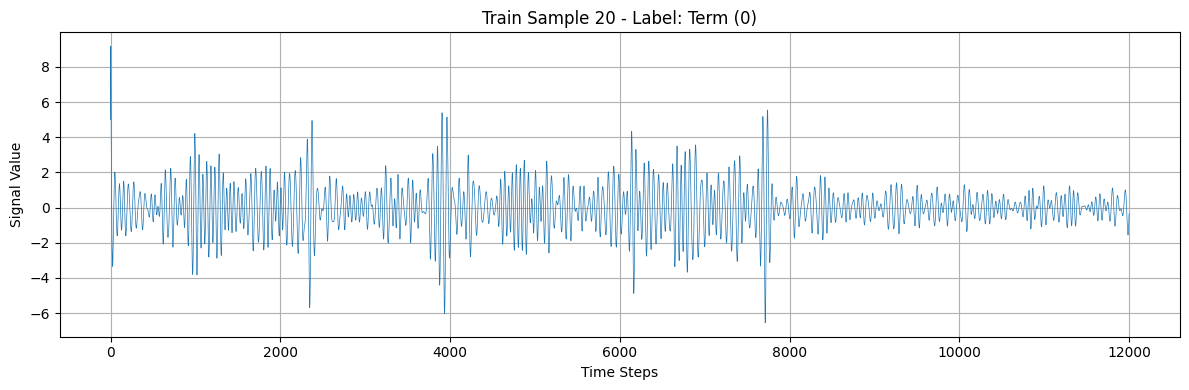

Label for sample 20: 0.0


In [41]:
'''Plottin example training instance'''
import matplotlib.pyplot as plt

# Select an index to inspect
idx = 20 

window, label = train_dataset[idx]
window_np = window.numpy()

plt.figure(figsize=(12, 4))
plt.plot(window_np, linewidth=0.5)
plt.title(f"Train Sample {idx} - Label: {'Preterm (1)' if label == 1 else 'Term (0)'}")
plt.xlabel("Time Steps")
plt.ylabel("Signal Value")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Label for sample {idx}: {label.item()}")


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Chomp1d(nn.Module):
    """Remove the extra padding on the right (to keep causality)."""
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size]

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCNClassifier(nn.Module):
    def __init__(self, input_size=1, num_channels=[32, 64], kernel_size=7, dropout=0.2):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = input_size if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1,
                                     dilation=dilation_size, padding=(kernel_size - 1) * dilation_size,
                                     dropout=dropout)]
        self.tcn = nn.Sequential(*layers)
        self.classifier = nn.Linear(num_channels[-1], 1)  # Binary classification

    def forward(self, x):
        x = x.unsqueeze(1)  # (B, 1, 12000) for 1D conv
        y = self.tcn(x)     # (B, C, L)
        y = y.mean(dim=2)   # Global average pooling over time
        out = self.classifier(y)
        return out.squeeze(1)  # (B,)


In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TCNClassifier().to(device)
wandb.watch(model, log='all', log_freq=10)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()  # outputs logits


In [44]:
import matplotlib.pyplot as plt

train_losses = []
test_losses = []

for epoch in range(wandb.config.epochs):
    # Train
    train_loss = train(model, train_loader, epoch)
    train_losses.append(train_loss)

    # Evaluate
    model.eval()
    test_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            test_loss += loss.item() * batch_x.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(avg_test_loss)

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    # Log metrics
    wandb.log({
        "train_loss": train_loss,
        "test_loss": avg_test_loss,
        "test_accuracy": acc,
        "test_f1": f1,
        "epoch": epoch
    })

    # Plot loss curves and log the figure to wandb
    plt.figure()
    plt.plot(range(1, epoch + 2), train_losses, label="Train Loss")
    plt.plot(range(1, epoch + 2), test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Test Loss")
    plt.legend()
    plt.grid(True)
    wandb.log({"Loss Curve": wandb.Image(plt)})
    plt.close()

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Test Loss={avg_test_loss:.4f}, Acc={acc:.4f}, F1={f1:.4f}")
